In [2]:
import numpy as np
import wandb

from scorta.recsys.candidate_generate import CandidateMerger
from atma_16.dataset.dataset import AtmaData16Loader
from pathlib import Path
import polars as pl

from hydra import initialize, compose
from scorta.utils.utils import seed_everything

from scorta.feature.feature import FeatureMerger
import pandas as pd
import seaborn as sns

In [3]:
seed_everything()

exp_name = "012_add_seened_yad"
input_dir = Path("../input")
candidate_dir = input_dir / "candidate"
candidate_dir.mkdir(exist_ok=True)

feature_dir = input_dir / "feature"
feature_dir.mkdir(exist_ok=True)

output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)


with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")
    print(cfg.feature)

wandb.init(project="atma16", config=dict(cfg))

dl = AtmaData16Loader(input_dir)
train_log = dl.load_train_log()

yado = dl.load_yado()
target_df = dl.load_train_label().with_columns(pl.lit(1).alias("target"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'SessionYadoRaw': {'feature_cols': ['seq_no'], 'key_cols': ['yad_no', 'session_id']}, 'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'], 'key_cols': ['yad_no']}, 'Session': {'feature_cols': ['user_mode_wid_cd', 'user_mode_ken_cd', 'user_mode_lrg_cd', 'user_mode_sml_cd', 'user_seq_cnt', 'user_mean_total_room_cnt', 'user_mean_wireless_lan_flg', 'user_mean_onsen_flg', 'user_mean_kd_stn_5min', 'user_mean_kd_bch_5min', 'user_mean_kd_slp_5min', 'user_mean_kd_conv_walk_5min'], 'key_cols': ['session_id']}, 'YadoRank': {'feature_cols': ['yad_cnt', 'yad_cnt_rank', 'yad_cnt_rank_wid_cd', 'yad_cnt_rank_ken_cd', 'yad_cnt_rank_lrg_cd', 'yad_cnt_rank_sml_cd'], 'key_cols': ['yad_no']}, 'MatchModeCD': {'feature_cols': ['is_match_mode_wid_cd', 'is_match_mode_ken_cd', 'is_match_mode_lrg_cd', 'is_match_mode_sml_cd'], 'key_cols': ['session_id', 'yad_no']}, 'Ya

wandb: Currently logged in as: zerebom. Use `wandb login --relogin` to force relogin


In [4]:
train_log = dl.load_train_log()
label = dl.load_train_label()
test_log = dl.load_train_log()

In [24]:
from atma_16.candidate.candidate import (
    LastSeenedCandidate,
    PopularAtCDCandidate,
    ImplicitCandidate,
    # TopBookedFromLastViewCandidate,
    CoVisitCandidate,
)


import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
import os
from implicit.nearest_neighbours import bm25_weight

os.environ["OPENBLAS_NUM_THREADS"] = "32"
IS_GENERATE = False


def make_csr_matrix(log: pl.DataFrame) -> sp.csr_matrix:
    target = np.ones(len(log)).astype(int)
    ses_ids = log["session_id"].to_numpy().astype(int)
    yad_ids = log["yad_no"].to_numpy().astype(int)
    mat = sp.csr_matrix((target, (ses_ids, yad_ids)))
    mat = sp.csr_matrix(bm25_weight(mat, K1=100, B=0.8))
    return mat


all_log = dl.load_all_log()
mat = make_csr_matrix(all_log)
all_ses_ids = all_log["session_id"].unique().to_numpy()

train_candidates = [
    ImplicitCandidate(dl, AlternatingLeastSquares(**cfg.als), mat, candidate_dir, mode="train", target_df=target_df),
    CoVisitCandidate(dl, candidate_dir, target_df=target_df),
    # TopBookedFromLastViewCandidate(dl, candidate_dir, target_df=target_df),
    LastSeenedCandidate(dl, candidate_dir, target_df=target_df),
    PopularAtCDCandidate(dl, candidate_dir, target_df=target_df),
]
test_candidates = [
    ImplicitCandidate(dl, AlternatingLeastSquares(**cfg.als), mat, candidate_dir, mode="test"),
    CoVisitCandidate(dl, candidate_dir, mode="test"),
    # TopBookedFromLastViewCandidate(dl, candidate_dir, mode="test"),
    LastSeenedCandidate(dl, candidate_dir, mode="test"),
    PopularAtCDCandidate(dl, candidate_dir, mode="test"),
]

cands_dic = {"train": train_candidates, "test": test_candidates}

all_eval_df = pd.DataFrame()
for mode, candidates in cands_dic.items():
    print(mode)
    if IS_GENERATE:
        for cand in candidates:
            df = cand.generate()
            cand.save(df)
            if mode == "train":
                eval_df = cand.evaluator.evaluate(df, cand.class_name)
                all_eval_df = pd.concat([all_eval_df, eval_df])

    cm = CandidateMerger(
        dl, candidates, output_dir=candidate_dir, mode=mode, target_df=target_df if mode == "train" else None
    )
    merged_df = cm.merge()
    cm.save(merged_df)
    if mode == "train":
        eval_df = cm.evaluator.evaluate(merged_df, cm.class_name)
        all_eval_df = pd.concat([all_eval_df, eval_df])


wandb.log({"candidate_table": wandb.Table(dataframe=all_eval_df)})

train


4it [00:08,  2.13s/it]


test


4it [00:05,  1.39s/it]


In [25]:
train_df = CandidateMerger(dl, train_candidates, output_dir=candidate_dir, mode="train").load()
test_df = CandidateMerger(dl, test_candidates, output_dir=candidate_dir, mode="test").load()
train_label = dl.load_train_label().with_columns(pl.lit(1).alias("label"))

train_df = train_df.join(train_label, on=["session_id", "yad_no"], how="left").with_columns(
    pl.col("label").fill_null(0)
)

ideal_makp = len(train_df.join(label, on=["session_id", "yad_no"], how="inner")) / train_df["session_id"].n_unique()
wandb.log({"idal_makp": ideal_makp})
print(ideal_makp)

# wandb.log({"candidate no hist": plt.hist(train_df.group_by("session_id").count().to_pandas()["count"])})

0.7675286978087829


In [26]:
from atma_16.feature.feature import (
    SeenedYadoFeature,
    YadoRawFeature,
    YadoRankFeature,
    SessionFeature,
    MatchModeCDFeature,
    Feature,
    SessionYadoRawFeature,
    YadoSesMeanFeature,
    DiffUserLastAndPredFeature,
)

In [27]:
with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")
    print(cfg)

train_feats = [
    SeenedYadoFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.SeenedYado),
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.Session),
    SessionYadoRawFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.SessionYadoRaw),
    YadoSesMeanFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoSesMean),
]

test_feats = [
    SeenedYadoFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.SeenedYado),
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.Session),
    SessionYadoRawFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.SessionYadoRaw),
    YadoSesMeanFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoSesMean),
]

train_feat_depend_feats = [
    MatchModeCDFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.MatchModeCD),
    # DiffUserLastAndPredFeature(
    #     output_dir=feature_dir,
    #     data_loader=dl,
    #     mode="train",
    #     yad_ses_feat=YadoSesMeanFeature(
    #         output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoSesMean
    #     ),
    #     **cfg.feature.DiffUserLastAndPred,
    # ),
]
test_feat_depend_feats = [
    # DiffUserLastAndPredFeature(
    #     output_dir=feature_dir,
    #     data_loader=dl,
    #     yad_ses_feat=YadoSesMeanFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoSesMean),
    #     **cfg.feature.DiffUserLastAndPred,
    # ),
    MatchModeCDFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.MatchModeCD),
]


def create_feats(df: pl.DataFrame, feats: list[Feature]):
    for feat in feats:
        feat_df = feat.fit(df)
        feat.save(feat_df)


def create_merged_df(df: pl.DataFrame, feats: list[Feature]):
    fm = FeatureMerger(output_dir=feature_dir, features=feats, mode=mode)
    merged_df = fm.merge(df)
    fm.save(merged_df)
    return merged_df


create_feats(train_df, train_feats)
train_merged_df = create_merged_df(train_df, train_feats)
create_feats(train_merged_df, train_feat_depend_feats)
train_df = create_merged_df(train_df, train_feats + train_feat_depend_feats)

create_feats(train_df, test_feats)
test_merged_df = create_merged_df(test_df, test_feats)
create_feats(test_merged_df, test_feat_depend_feats)
test_df = create_merged_df(test_df, test_feats + test_feat_depend_feats)

{'debug': False, 'seed': 113, 'fold_num': 5, 'als': {'factors': 100, 'regularization': 0.05, 'alpha': 2.0, 'calculate_training_loss': True, 'iterations': 15}, 'gbdt': {'lgb': {'model_params': {'num_boost_round': 10000, 'objective': 'binary', 'metric': 'binary_logloss', 'random_state': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'seed': 42, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'num_leaves': 32, 'min_data_in_leaf': 20, 'max_depth': -1, 'max_bin': 255, 'n_jobs': -1, 'importance_type': 'gain'}, 'train_params': {'early_stopping_rounds': 50}}, 'cat': {'model_params': {'iterations': 10000, 'loss_function': 'Logloss', 'random_seed': 42, 'early_stopping_rounds': 50, 'task_type': 'GPU'}, 'train_params': {'verbose_eval': 250, 'early_stopping_round': 50}}}, 'feature': {'SessionYadoRaw': {'feature_cols': ['seq_no'], 'key_cols': ['yad_no', 'session_id']}, 'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch

 33%|███▎      | 2/6 [00:00<00:00,  6.93it/s]

SeenedYadoFeature_train (8346159, 25)
YadoRawFeature (8346159, 37)
YadoRankFeature_train (8346159, 43)
SessionFeature_train

 67%|██████▋   | 4/6 [00:00<00:00,  6.83it/s]

 (8346159, 62)


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]

SessionYadoRawFeature_train (8375357, 63)
YadoSesMeanFeature_train (8375357, 69)



 29%|██▊       | 2/7 [00:00<00:00,  7.38it/s]

SeenedYadoFeature_train (8346159, 25)
YadoRawFeature (8346159, 37)


 57%|█████▋    | 4/7 [00:00<00:00,  7.01it/s]

YadoRankFeature_train (8346159, 43)
SessionFeature_train (8346159, 62)


 86%|████████▌ | 6/7 [00:01<00:00,  4.92it/s]

SessionYadoRawFeature_train (8375357, 63)
YadoSesMeanFeature_train (8375357, 69)


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

MatchModeCDFeature_train (8522165, 73)


(11223, 11)


 33%|███▎      | 2/6 [00:00<00:00, 10.62it/s]

SeenedYadoFeature_test (4646825, 23)
YadoRawFeature (4646825, 35)
YadoRankFeature_test (4646825, 41)


 67%|██████▋   | 4/6 [00:00<00:00, 11.05it/s]

SessionFeature_test (4646825, 60)


100%|██████████| 6/6 [00:00<00:00,  8.98it/s]

SessionYadoRawFeature_test (4663417, 61)
YadoSesMeanFeature_test (4663417, 67)



 29%|██▊       | 2/7 [00:00<00:00, 10.64it/s]

SeenedYadoFeature_test (4646825, 23)
YadoRawFeature (4646825, 35)
YadoRankFeature_test (4646825, 41)


 57%|█████▋    | 4/7 [00:00<00:00, 11.01it/s]

SessionFeature_test (4646825, 60)


 86%|████████▌ | 6/7 [00:00<00:00,  8.14it/s]

SessionYadoRawFeature_test (4663417, 61)
YadoSesMeanFeature_test (4663417, 67)


100%|██████████| 7/7 [00:01<00:00,  5.83it/s]

MatchModeCDFeature_test (4741897, 71)


In [28]:
train_df = train_df.drop_nulls(subset="yad_no").unique(subset=["session_id", "yad_no"])
test_df = test_df.drop_nulls(subset="yad_no").unique(subset=["session_id", "yad_no"])

In [29]:
test_pdf = test_df.drop(["session_id", "yad_no"]).to_pandas()

X_train = train_df.drop(["fold", "label", "session_id", "yad_no"]).to_numpy()
y_train = train_df["label"].to_numpy().flatten()
print(X_train.shape, y_train.shape)

(8336615, 69) (8336615,)


In [30]:
# cv = ColumnBasedCV(dl)

from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
# GBDT class
from typing import Any, Callable, Literal, TypeAlias
from catboost import CatBoost, Pool
from lightgbm import LGBMClassifier, LGBMRegressor, LGBMRanker
import lightgbm as lgb

GBDType: TypeAlias = Literal["cat", "xgb", "lgb"]
TaskType: TypeAlias = Literal["bin", "reg", "multi", "rank"]


class GBDT:
    def __init__(
        self,
        gbdt_type: GBDType = "cat",
        task_type: TaskType = "bin",
        model_params: dict[str, Any] | None = None,
        train_params: dict[str, Any] | None = None,
        cv: Callable | None = None,
        callbacks: list[Callable] | None = None,
        **kwargs: Any,
    ):
        self.gbt_type = gbdt_type
        self.task_type = task_type
        self.cv = cv

        if self.cv is None:
            self.cv = KFold(n_splits=5, shuffle=True, random_state=42)

        self.model_params = model_params
        self.train_params = train_params
        self.callbacks = callbacks
        self.kwargs = kwargs


class LGB(GBDT):
    """
    ex. callbacks:
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=True),
            lgb.log_evaluation(10),
        ],
    ex. train_params: {"num_boost_round": 10000}
    """

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_classes = len(np.unique(y))
        self.models = []
        match self.task_type:
            case "bin" | "multi":
                oof = np.zeros(shape=(len(y), n_classes), dtype=np.float32)
            case "reg" | "rank":
                oof = np.zeros(shape=(len(y)), dtype=np.float32)

        for idx_tr, idx_val in cv.split(X, y):  # type: ignore
            match self.task_type:
                case "bin" | "multi":
                    self.model = LGBMClassifier(**self.model_params)
                case "reg":
                    self.model = LGBMRegressor(**self.model_params)
                case "rank":
                    self.model = LGBMRanker(**self.model_params)

            X_tr, y_tr = X[idx_tr], y[idx_tr]
            X_val, y_val = X[idx_val], y[idx_val]

            self.model.fit(
                X_tr,
                y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=self.callbacks,  # type: ignore
            )

            oof[idx_val] = (
                self.model.predict_proba(X_val) if self.task_type in ("bin", "multi") else self.model.predict(X_val)
            )
            self.models.append(self.model)
        return self.models, oof

    def predict(self, X: np.ndarray, model_idx: int):
        return self.models[model_idx].predict_proba(X)

    def feature_importance(self):
        return [model.feature_importances_ for model in self.models]


class CAT(GBDT):
    def fit(self, X: np.ndarray, y: np.ndarray):
        n_classes = len(np.unique(y))
        self.models = []

        match self.task_type:
            case "bin" | "multi":
                self.model = CatBoost(params=self.model_params)
                oof = np.zeros(shape=(len(y), n_classes), dtype=np.float32)

        for idx_tr, idx_val in cv.split(X, y):  # type: ignore
            X_tr, y_tr = X[idx_tr], y[idx_tr]
            X_val, y_val = X[idx_val], y[idx_val]

            clf_train = Pool(X_tr, y_tr)
            clf_val = Pool(X_val, y_val)
            self.model.fit(clf_train, eval_set=[clf_val])

            oof[idx_val] = (
                self.model.predict(X_val, prediction_type="Probability")
                if self.task_type in ("bin", "multi")
                else self.model.predict(X_val)
            )
            self.models.append(self.model)
        return self.models, oof

In [32]:
cfg

{'debug': False, 'seed': 113, 'fold_num': 5, 'als': {'factors': 100, 'regularization': 0.05, 'alpha': 2.0, 'calculate_training_loss': True, 'iterations': 15}, 'gbdt': {'lgb': {'model_params': {'num_boost_round': 10000, 'objective': 'binary', 'metric': 'binary_logloss', 'random_state': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'seed': 42, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'num_leaves': 32, 'min_data_in_leaf': 20, 'max_depth': -1, 'max_bin': 255, 'n_jobs': -1, 'importance_type': 'gain'}, 'train_params': {'early_stopping_rounds': 50}}, 'cat': {'model_params': {'iterations': 10000, 'loss_function': 'Logloss', 'random_seed': 42, 'early_stopping_rounds': 50, 'task_type': 'GPU'}, 'train_params': {'verbose_eval': 250, 'early_stopping_round': 50}}}, 'feature': {'SessionYadoRaw': {'feature_cols': ['seq_no'], 'key_cols': ['yad_no', 'session_id']}, 'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch

In [33]:
with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")

In [34]:
lgb_wrapper = LGB(
    gbdt_type="lgb",
    task_type="bin",
    model_params=cfg.gbdt.lgb.model_params,
    train_params=cfg.gbdt.lgb.train_params,
    cv=cv,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(250),
    ],
)

# cat_wrapper = CAT(
#     gbdt_type="cat",
#     task_type="bin",
#     model_params=dict(cfg.gbdt.cat.model_params),
#     train_params=dict(cfg.gbdt.cat.train_params),
#     cv=cv,
# )
models, oof = lgb_wrapper.fit(X_train, y_train)
# models, oof = cat_wrapper.fit(X_train, y_train)

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.07183


/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0722973


/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.0722197


/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0716749


/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0723058


In [35]:
from atma_16.utils.metrics import mapk

oof_df = (
    train_df[["session_id", "yad_no", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .filter(pl.col("session_id").is_in(dl.load_train_log()["session_id"].unique().to_numpy()))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no"))["yad_no"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
oof_score = mapk(y_true, oof_lists, 10)
print(oof_score)

oof_df.write_parquet(output_dir / f"oof_{oof_score}.parquet")
wandb.log({"oof_score": oof_score})

0.40186140853281016


In [36]:
import numpy as np

# preds = np.array([lgb_wrapper.predict(test_pdf, i) for i in range(5)]).mean(axis=0)
preds = np.array([lgb_wrapper.models[i].predict_proba(test_pdf)[:, 1] for i in range(5)]).mean(axis=0)
sub = test_df.with_columns(pl.Series(preds).alias("score"))[["session_id", "yad_no", "score"]]

In [39]:
train_df

session_id,yad_no,ImplicitCandidate_score,ImplicitCandidate_rank,CoVisitCandidate_rank,CoVisitCandidate_score,LastSeenedCandidate_score,LastSeenedCandidate_rank,PopularAtCDCandidate_score,PopularAtCDCandidate_rank,cand_selected_cnt,sum_score,rank,fold,label,seened_yad_no_0,seened_yad_no_1,seened_yad_no_2,seened_yad_no_3,seened_yad_no_4,seened_yad_no_5,seened_yad_no_6,seened_yad_no_7,seened_yad_no_8,seened_yad_no_9,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,yad_cnt,yad_cnt_rank,yad_cnt_rank_wid_cd,yad_cnt_rank_ken_cd,yad_cnt_rank_lrg_cd,yad_cnt_rank_sml_cd,user_mode_wid_cd,user_mode_ken_cd,user_mode_lrg_cd,user_mode_sml_cd,user_seq_cnt,user_mean_total_room_cnt,user_mean_wireless_lan_flg,user_mean_onsen_flg,user_mean_kd_stn_5min,user_mean_kd_bch_5min,user_mean_kd_slp_5min,user_mean_kd_conv_walk_5min,user_std_total_room_cnt,user_std_wireless_lan_flg,user_std_onsen_flg,user_std_kd_stn_5min,user_std_kd_bch_5min,user_std_kd_slp_5min,user_std_kd_conv_walk_5min,seq_no,this_session_seq_len_yad_mean,another_session_seq_len_yad_mean,this_count_yad_mean,another_count_yad_mean,this_ratio_yad_mean,another_ratio_yad_mean,is_match_mode_wid_cd,is_match_mode_ken_cd,is_match_mode_lrg_cd,is_match_mode_sml_cd
i64,i64,i64,i64,u32,f64,f64,u32,f64,u32,u32,f64,f64,i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64,f64,i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,u32,u32,f64,f64,i64,i64,i64,i64
4,11380,0,10,8,0.003697,null,null,null,null,2,0.003697,11.0,null,0,96,898,null,null,null,null,null,null,null,null,0,111.0,1.0,0,1.0,0.0,0.0,1.0,10,19,76,82,76,2357,180,14,11,11,10,19,76,82,2,186.5,1.0,0.0,0.0,0.0,0.0,1.0,58.689863,0.0,0.0,0.0,0.0,0.0,0.0,null,1.907895,1.706897,76,58,0.567164,0.432836,1,1,1,1
4,1284,0,7,9,0.002875,null,null,null,null,2,0.002875,12.0,null,0,96,898,null,null,null,null,null,null,null,null,0,176.0,1.0,0,0.0,0.0,0.0,1.0,10,19,76,82,78,12130,172,13,10,10,10,19,76,82,2,186.5,1.0,0.0,0.0,0.0,0.0,1.0,58.689863,0.0,0.0,0.0,0.0,0.0,0.0,null,1.910256,1.746032,78,63,0.553191,0.446809,1,1,1,1
7,5445,null,null,45,0.000205,null,null,0.021646,4,2,0.021851,7.0,null,0,13106,null,null,null,null,null,null,null,null,null,0,295.0,1.0,0,1.0,0.0,0.0,1.0,8,31,56,58,278,8089,7,7,7,4,8,31,56,58,1,60.0,1.0,0.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,1.938849,2.257282,278,206,0.57438,0.42562,1,1,1,1
7,6980,null,null,63,0.000205,null,null,null,null,1,0.000205,59.5,null,0,13106,null,null,null,null,null,null,null,null,null,0,126.0,1.0,0,1.0,0.0,0.0,1.0,8,31,56,58,69,6609,161,84,72,31,8,31,56,58,1,60.0,1.0,0.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,1.376812,1.72,69,50,0.579832,0.420168,1,1,1,1
8,9723,null,null,9,0.000411,null,null,null,null,1,0.000411,14.5,null,0,12062,null,null,null,null,null,null,null,null,null,0,178.0,1.0,0,0.0,0.0,0.0,1.0,9,16,198,259,59,3959,81,34,17,13,9,16,198,259,1,51.0,1.0,0.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,1.542373,1.542857,59,35,0.62766,0.37234,1,1,1,1
9,3278,0,8,4,0.004108,null,null,null,null,2,0.004108,8.0,null,0,4866,null,null,null,null,null,null,null,null,null,0,100.0,1.0,0,0.0,0.0,0.0,1.0,2,3,112,132,51,10199,654,395,30,18,2,3,112,132,1,238.0,1.0,0.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,2.078431,1.978723,51,47,0.520408,0.479592,1,1,1,1
9,10461,null,null,15,0.000205,null,null,0.008986,5,2,0.009192,5.0,null,0,4866,null,null,null,null,null,null,null,null,null,0,196.0,1.0,0,1.0,0.0,0.0,1.0,2,3,112,132,116,3244,180,85,8,5,2,3,112,132,1,238.0,1.0,0.0,1.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,2.094828,1.744681,116,47,0.711656,0.288344,1,1,1,1
14,11923,0,8,2,0.010064,null,null,null,null,2,0.010064,9.0,null,0,143,7913,null,null,null,null,null,null,null,null,0,204.0,1.0,0,1.0,0.0,0.0,1.0,2,2,35,98,52,1826,651,96,15,15,2,2,35,98,2,155.5,1.0,0.0,1.0,0.0,0.0,1

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

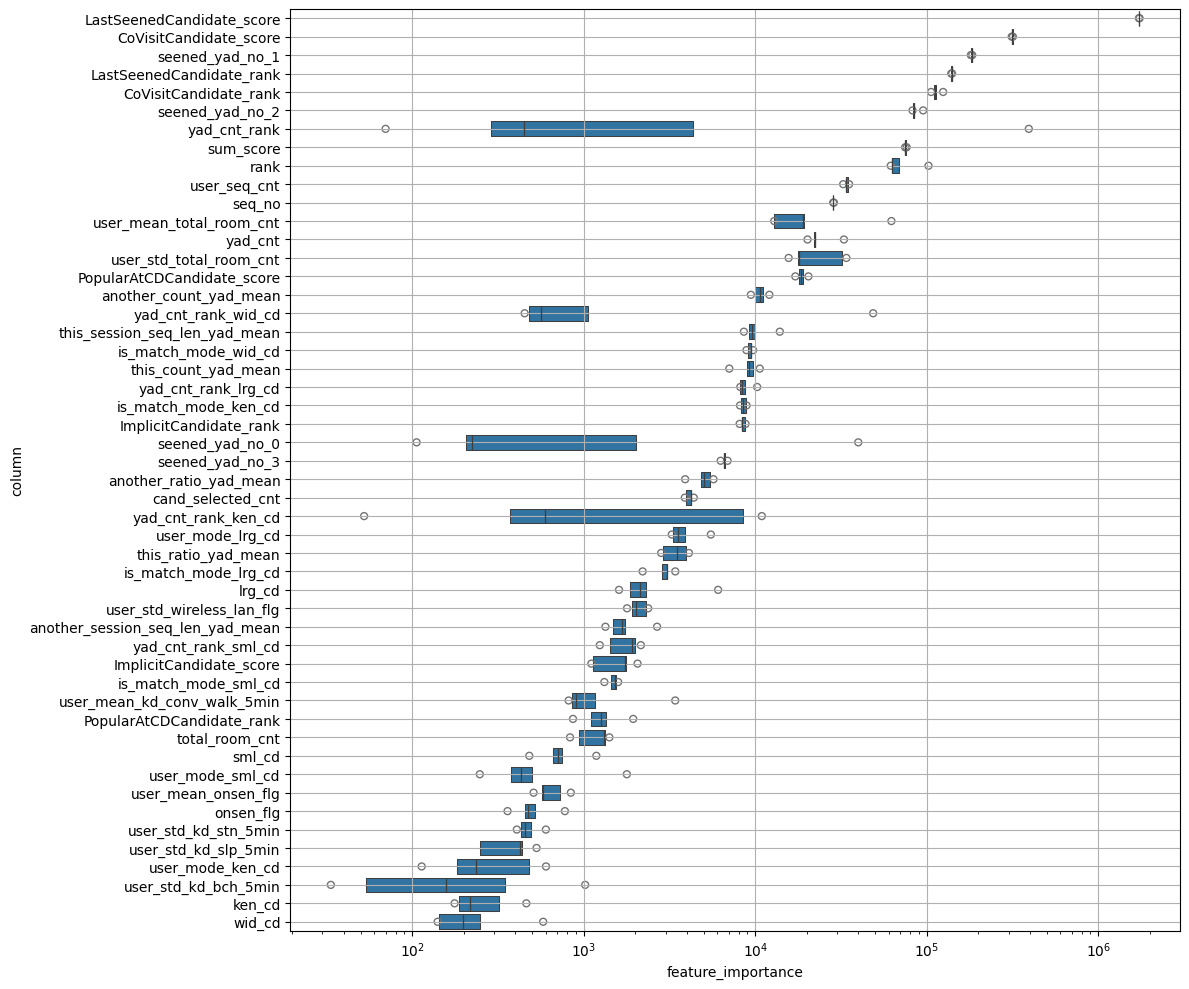

In [38]:
from scorta.eda import df as eda_df


eda_df.visualize_importance(lgb_wrapper.feature_importance(), train_df.drop(["fold", "label", "session_id", "yad_no"]))

<Axes: ylabel='Count'>

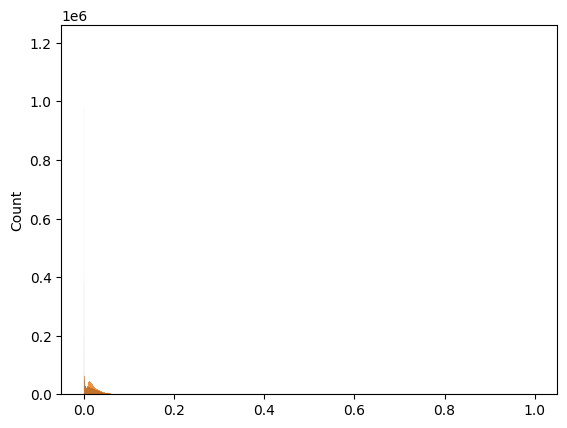

In [19]:
import seaborn as sns

sns.histplot(preds)
sns.histplot(oof[:, 1])

In [40]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .filter(pl.col("session_id").is_in(dl.load_test_log()["session_id"].unique().to_numpy()))
    .group_by("session_id", maintain_order=True)
    .agg("yad_no")["yad_no"]
    .to_list()
)

In [41]:
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    dl.load_test_log()
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(test_top30_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

In [42]:
np.array(fill_sub_lists).shape

(174700, 10)

In [43]:
sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv(f"../output/{exp_name}/sub_df_{oof_score}_add_feat.csv", index=False)